# Designing and training autoencoders using Python

In this notebook, we illustrate how to implement several of the autoencoder models introduced in the preceding section using Keras. We first load and prepare an image dataset that we use throughout this section because it makes it easier to visualize the results of the encoding process.

We then proceed to build autoencoders using deep feedforward nets, sparsity constraints, and convolutions and then apply the latter to denoise images.

Source: https://blog.keras.io/building-autoencoders-in-keras.html

## Imports & Settings

In [ ]:
from os.path import join
import pandas as pd

import numpy as np
from numpy.random import choice
from numpy.linalg import norm
import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
from mpl_toolkits.axes_grid1 import make_axes_locatable

from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras import regularizers
from keras.models import Model, model_from_json
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from keras.datasets import fashion_mnist
from keras import backend as K

from sklearn.preprocessing import minmax_scale
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split

from scipy.spatial.distance import pdist, cdist

In [ ]:
%matplotlib inline
plt.style.use('ggplot')
n_classes = 10 # all examples have 10 classes
cmap = sns.color_palette('Paired', n_classes)
pd.options.display.float_format = '{:,.2f}'.format

## Fashion MNIST Data

For illustration, we'll use the Fashion MNIST dataset, a modern drop-in replacement for the classic MNIST handwritten digit dataset popularized by Yann LeCun with LeNet in the 1990s.

In [ ]:
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Keras makes it easy to access the 60,000 train and 10,000 test grayscale samples with a resolution of 28 x 28 pixels:

In [ ]:
X_train.shape, X_test.shape

((60000, 28, 28), (10000, 28, 28))

In [ ]:
image_size = 28     # size of image (pixels per side)
input_size = image_size ** 2 # Compression factor: 784 / 32 = 24.5

In [ ]:
class_dict = {0: 'T-shirt/top',
              1: 'Trouser',
              2: 'Pullover',
              3: 'Dress',
              4: 'Coat',
              5: 'Sandal',
              6: 'Shirt',
              7: 'Sneaker',
              8: 'Bag',
              9: 'Ankle boot'}
classes = list(class_dict.keys())

### Plot sample images

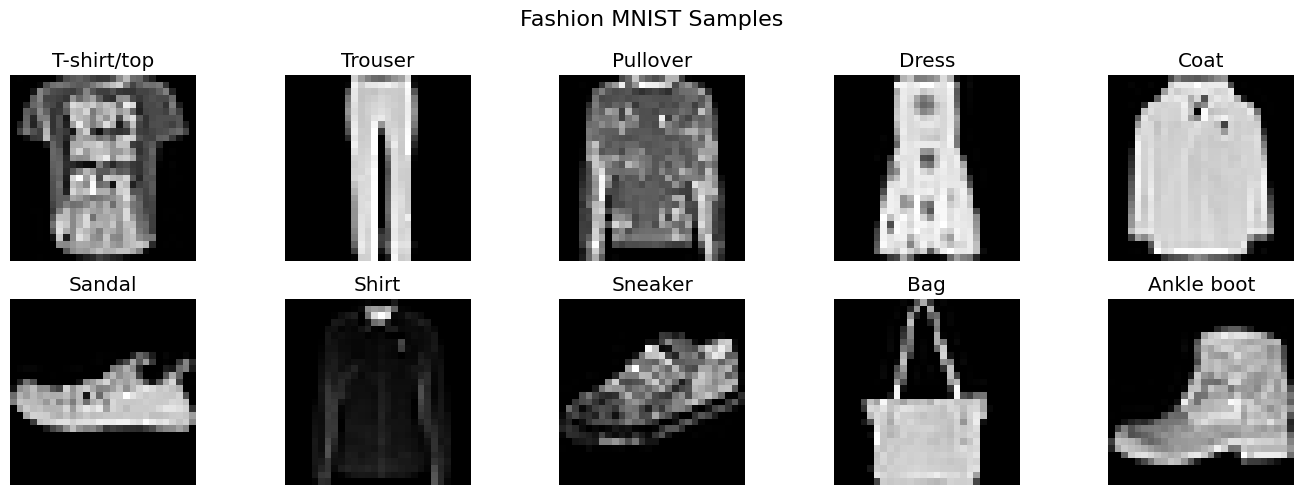

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(14, 5))
axes =axes.flatten()
for row, label in enumerate(classes):
    label_idx = np.argwhere(y_train == label).squeeze()
    axes[row].imshow(X_train[choice(label_idx)], cmap='gray')
    axes[row].axis('off')
    axes[row].set_title(class_dict[row])

fig.suptitle('Fashion MNIST Samples', fontsize=16)
fig.tight_layout()
fig.subplots_adjust(top=.85)

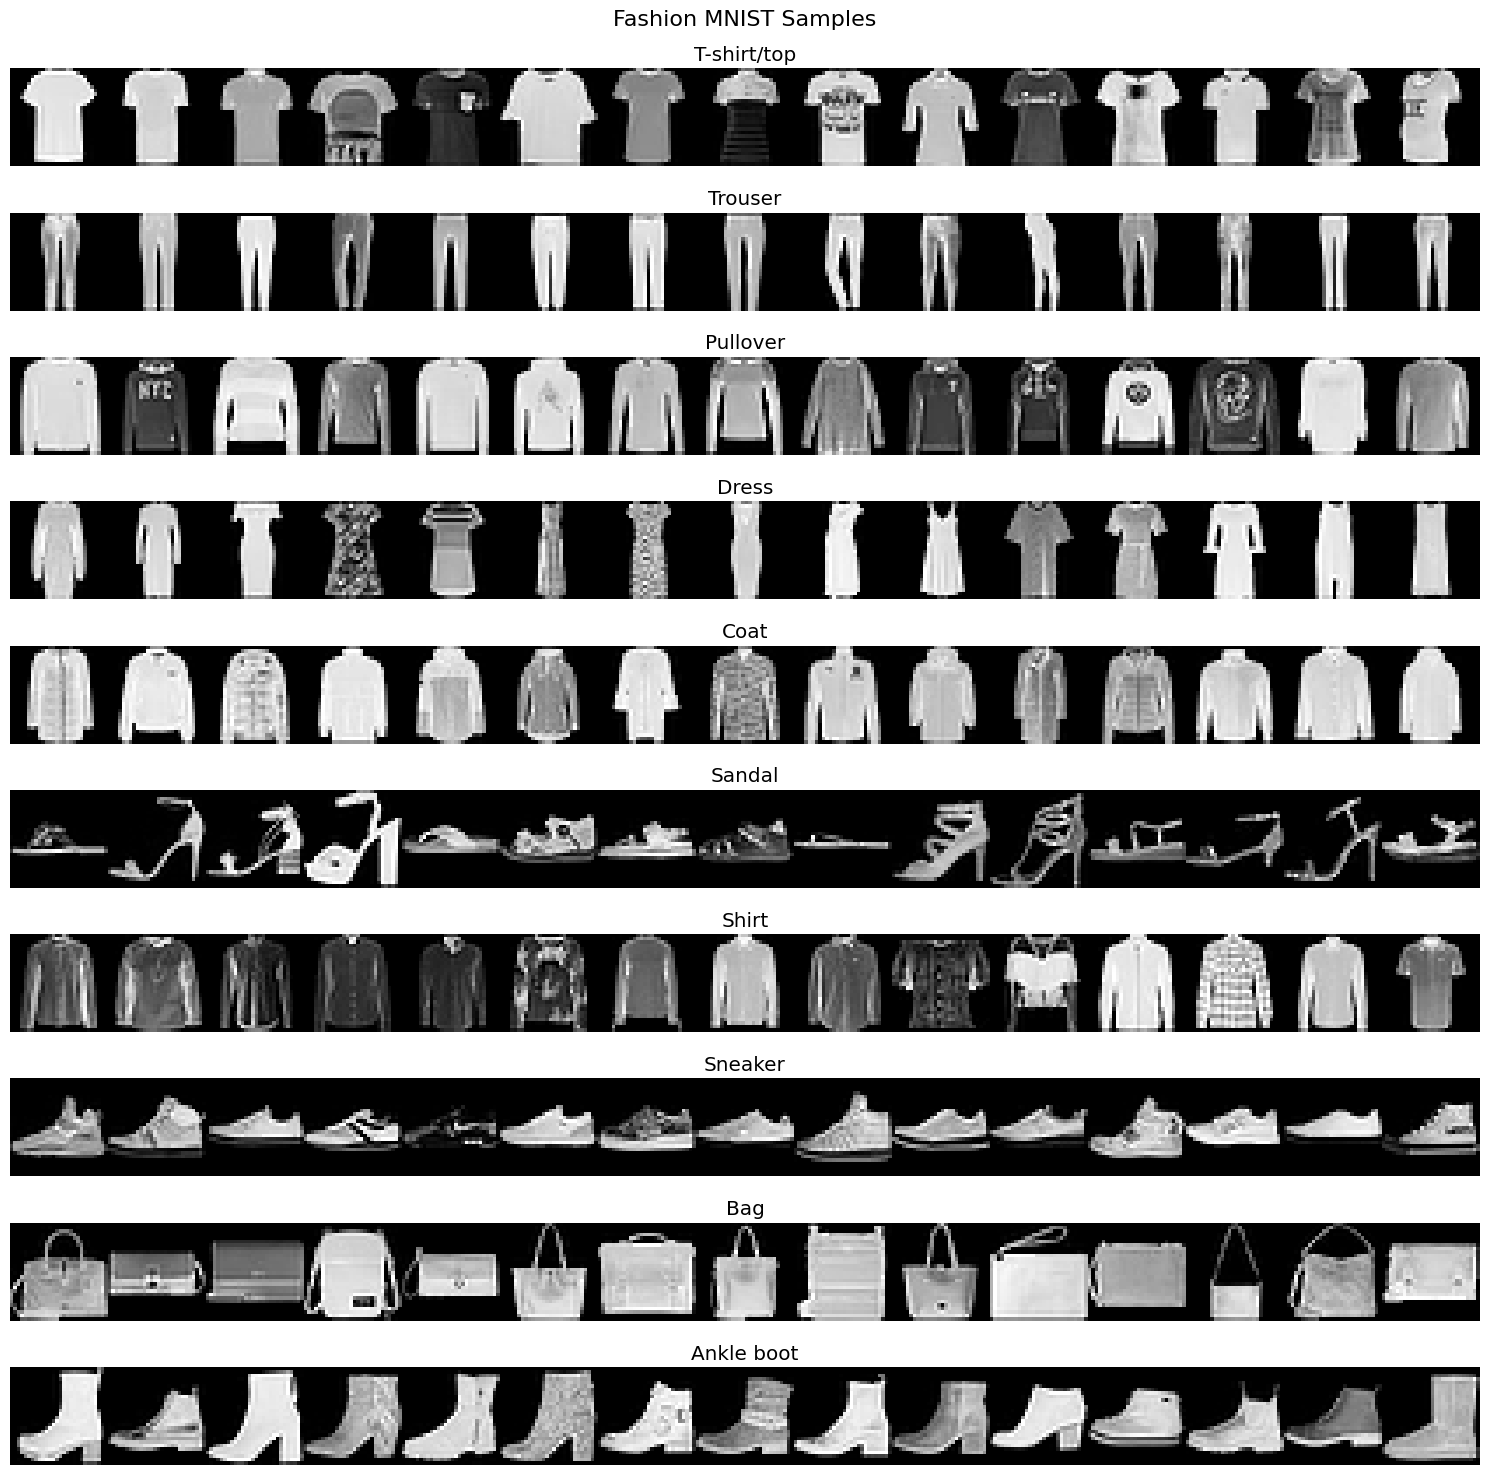

In [ ]:
n_samples = 15
fig, axes = plt.subplots(nrows=n_classes, figsize=(15, 15))
axes =axes.flatten()
for row, label in enumerate(classes):
    class_imgs = np.empty(shape=(image_size, n_samples * image_size))
    label_idx = np.argwhere(y_train == label).squeeze()
    class_samples = choice(label_idx, size=n_samples, replace=False)
    for col, sample in enumerate(class_samples):
        i = col * image_size
        class_imgs[:, i:i + image_size] = X_train[sample]
    axes[row].imshow(class_imgs, cmap='gray')
    axes[row].axis('off')
    axes[row].set_title(class_dict[row])

fig.suptitle('Fashion MNIST Samples', fontsize=16)
fig.tight_layout()
fig.subplots_adjust(top=.95, bottom=0)

## Reshape & normalize Fashion MNIST data

We reshape the data so that each image is represented by a flat one-dimensional pixel vector with 28 x 28 = 784 elements normalized to the range of [0, 1]:

In [ ]:
encoding_size = 32 # Size of encoding

In [ ]:
def data_prep(x, size=input_size):
    return x.reshape(-1, size).astype('float32')/255

In [ ]:
X_train_scaled = data_prep(X_train)
X_test_scaled = data_prep(X_test)

In [ ]:
X_train_scaled.shape, X_test_scaled.shape

((60000, 784), (10000, 784))

## Vanilla single-layer autoencoder

We start with a vanilla feedforward autoencoder with a single hidden layer to illustrate the general design approach using the functional Keras API and establish a performance baseline.

Encoding 28 x 28 images to a 32 value representation for a compression factor of 24.5

### Single-layer Model

#### Input Layer

In [ ]:
input_ = Input(shape=(input_size,), name='Input')

#### Dense Encoding Layer

The encoder part of the model consists of a fully-connected layer that learns the new, compressed representation of the input. We use 32 units for a compression ratio of 24.5:

In [ ]:
encoding = Dense(units=encoding_size,
                 activation='relu',
                 name='Encoder')(input_)

#### Dense Reconstruction Layer

The decoding part reconstructs the compressed data to its original size in a single step:

In [ ]:
decoding = Dense(units=input_size,
                 activation='sigmoid',
                 name='Decoder')(encoding)

#### Autoencoder Model

In [ ]:
autoencoder = Model(inputs=input_,
                    outputs=decoding,
                    name='Autoencoder')

The thus defined encoder-decoder computation uses almost 51,000 parameters:

In [ ]:
autoencoder.summary()

Model: "Autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Encoder (Dense)                 │ (None, 32)             │        25,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Decoder (Dense)                 │ (None, 784)            │        25,872 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,992 (199.19 KB)

 Trainable params: 50,992 (199.19 KB)

 Non-trainable params: 0 (0.00 B)

### Encoder Model

The functional API allows us to use parts of the model's chain as separate encoder and decoder models that use the autoencoder's parameters learned during training.

The encoder just uses the input and hidden layer with about half of the total parameters:

In [ ]:
encoder = Model(inputs=input_ ,
                outputs=encoding,
                name='Encoder')

In [ ]:
encoder.summary()

Model: "Encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Encoder (Dense)                 │ (None, 32)             │        25,120 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,120 (98.12 KB)

 Trainable params: 25,120 (98.12 KB)

 Non-trainable params: 0 (0.00 B)

Once we train the autoencoder, we can use the encoder to compress the data.

### Decoder Model

The decoder consists of the last autoencoder layer, fed by a placeholder for the encoded data:

#### Placeholder for encoded input

In [ ]:
encoded_input = Input(shape=(encoding_size,), name='Decoder_Input')

#### Extract last autoencoder layer

In [ ]:
decoder_layer = autoencoder.layers[-1](encoded_input)

#### Define Decoder Model

In [ ]:
decoder = Model(inputs=encoded_input,
                outputs=decoder_layer)

In [ ]:
decoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Decoder_Input (InputLayer)      │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Decoder (Dense)                 │ (None, 784)            │        25,872 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,872 (101.06 KB)

 Trainable params: 25,872 (101.06 KB)

 Non-trainable params: 0 (0.00 B)

### Compile the Autoencoder Model

In [ ]:
autoencoder.compile(optimizer='adam',
                    loss='mse')

### Train the autoencoder

We compile the model to use the Adam optimizer to minimize the MSE between the input data and the reproduction achieved by the autoencoder. To ensure that the autoencoder learns to reproduce the input, we train the model using the same input and output data:

#### Create `early_stopping` callback

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss',
                               min_delta=1e-5,
                               patience=5,
                               verbose=0,
                               restore_best_weights=True,
                               mode='auto')

#### Create TensorBard callback to visualize network performance

In [ ]:
tb_callback = TensorBoard(log_dir='logs/autoencoder/mnist/',
                          histogram_freq=5,
                          write_graph=True,
                          write_images=True)

#### Create checkpoint callback

In [ ]:
filepath = 'models/fashion_mnist.autencoder.32.weights.h5'

In [ ]:
checkpointer = ModelCheckpoint(filepath=filepath,
                               monitor='val_loss',
                               verbose=0,
                               save_best_only=True,
                               save_weights_only=True,
                               mode='auto')

#### Fit the Model

To avoid running time, you can load the pre-computed results in the 'model' folder (see below)

In [ ]:
autoencoder.fit(x=X_train_scaled,
                y=X_train_scaled,
                epochs=100,
                batch_size=32,
                shuffle=True,
                validation_split=.1,
                callbacks=[tb_callback, early_stopping, checkpointer])

Epoch 1/100
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.0480 - val_loss: 0.0173
Epoch 2/100
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0161 - val_loss: 0.0144
Epoch 3/100
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0139 - val_loss: 0.0135
Epoch 4/100
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0133 - val_loss: 0.0131
Epoch 5/100
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0130 - val_loss: 0.0132
Epoch 6/100
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0128 - val_loss: 0.0130
Epoch 7/100
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0128 - val_loss: 0.0128
Epoch 8/100
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0127 - val_loss: 0.0128
Epoch 9/100
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.0126 - val_loss: 0.0127
Epoch 10/100
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0126 - val_loss: 0.0127
Epoch 11/100
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0126 - val_loss: 0.0127
Epoch 12/100
1688/1

### Reload weights from best-performing model

In [ ]:
autoencoder.load_weights(filepath)

### Evaluate trained model

Training stops after some 20 epochs with a test RMSE of 0.1122:

In [ ]:
mse = autoencoder.evaluate(x=X_test_scaled, y=X_test_scaled)
f'MSE: {mse:.4f} | RMSE {mse**.5:.4f}'

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0125


'MSE: 0.0126 | RMSE 0.1122'

### Encode and decode test images

To encode data, we use the encoder we just defined, like so:

In [ ]:
encoded_test_img = encoder.predict(X_test_scaled)
encoded_test_img.shape

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


(10000, 32)

The decoder takes the compressed data and reproduces the output according to the autoencoder training results:

In [ ]:
decoded_test_img = decoder.predict(encoded_test_img)
decoded_test_img.shape

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


(10000, 784)

#### Compare Original with Reconstructed Samples

The following figure shows ten original images and their reconstruction by the autoencoder and illustrates the loss after compression:

In [ ]:
import os

if not os.path.exists('figures'):
    os.makedirs('figures')

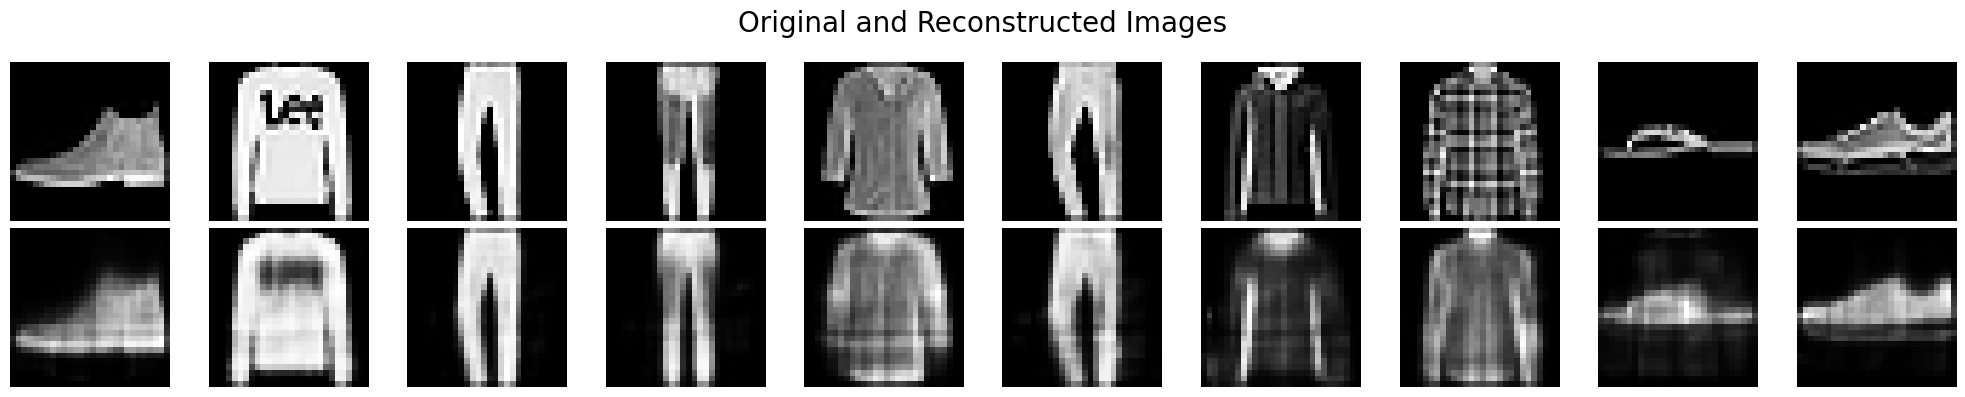

In [ ]:
fig, axes = plt.subplots(ncols=n_classes, nrows=2, figsize=(20, 4))
for i in range(n_classes):

    axes[0, i].imshow(X_test_scaled[i].reshape(image_size, image_size), cmap='gray')
    axes[0, i].axis('off')

    axes[1, i].imshow(decoded_test_img[i].reshape(28, 28) , cmap='gray')
    axes[1, i].axis('off')

fig.suptitle('Original and Reconstructed Images', fontsize=20)
fig.tight_layout()
fig.subplots_adjust(top=.85)
fig.savefig('figures/reconstructed', dpi=300)

## Combine training steps into function

The helper function `train_autoencoder` just summarizes some repetitive steps.

In [ ]:
def train_autoencoder(path, model, x_train=X_train_scaled, x_test=X_test_scaled):
    callbacks = [EarlyStopping(patience=5, restore_best_weights=True),
                 ModelCheckpoint(filepath=path, save_best_only=True, save_weights_only=True)]
    model.fit(x=x_train, y=x_train, epochs=100, validation_split=.1, callbacks=callbacks)
    model.load_weights(path)
    mse = model.evaluate(x=x_test, y=x_test)
    return model, mse

## Autoencoders with Sparsity Constraints

### Encoding Layer with L1 activity regularizer

The addition of regularization is fairly straightforward. We can apply it to the dense encoder layer using Keras' `activity_regularizer`, as follows:

In [ ]:
encoding_l1 = Dense(units=encoding_size,
                    activation='relu',
                    activity_regularizer = regularizers.l1(10e-5),
                    name='Encoder_L1')(input_)

### Decoding Layer

In [ ]:
decoding_l1 = Dense(units=input_size,
                    activation='sigmoid',
                    name='Decoder_L1')(encoding_l1)

In [ ]:
autoencoder_l1 = Model(input_, decoding_l1)

### Autoencoder Model

In [ ]:
autoencoder_l1.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Encoder_L1 (Dense)              │ (None, 32)             │        25,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Decoder_L1 (Dense)              │ (None, 784)            │        25,872 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,992 (199.19 KB)

 Trainable params: 50,992 (199.19 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
autoencoder_l1.compile(optimizer='adam',
                       loss='mse')

### Encoder & Decoder Models

In [ ]:
encoder_l1 = Model(inputs=input_, outputs=encoding_l1, name='Encoder')

In [ ]:
encoded_input = encoding_l1
decoder_l1_layer = autoencoder_l1.layers[-1](encoded_input)
decoder_l1 = Model(inputs=encoded_input, outputs=decoder_l1_layer)

### Train Model

In [54]:
path = 'models/fashion_mnist.autencoder_l1.32.weights.h5'
autoencoder_l1, mse = train_autoencoder(path, autoencoder_l1)

Epoch 1/100
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.1398 - val_loss: 0.0975
Epoch 2/100
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0943 - val_loss: 0.0895
Epoch 3/100
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0886 - val_loss: 0.0879
Epoch 4/100
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0875 - val_loss: 0.0875
Epoch 5/100
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0874 - val_loss: 0.0874
Epoch 6/100
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 0.0869 - val_loss: 0.0873
Epoch 7/100
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0869 - val_loss: 0.0873
Epoch 8/100
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0870 - val_loss: 0.0873
Epoch 9/100
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0871 - val_loss: 0.0873
Epoch 10/100
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0871 - val_loss: 0.0873
Epoch 11/100
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0872 - val_loss: 0.0873
Epoch 12/100
1688/1

### Evaluate Model

The input and decoding layers remain unchanged. In this example, with a compression of factor 24.5, regularization negatively affects performance with a test RMSE of 0.2946.

In [55]:
f'MSE: {mse:.4f} | RMSE {mse**.5:.4f}'

'MSE: 0.0866 | RMSE 0.2944'

In [ ]:
encoded_test_img = encoder_l1.predict(X_test_scaled)

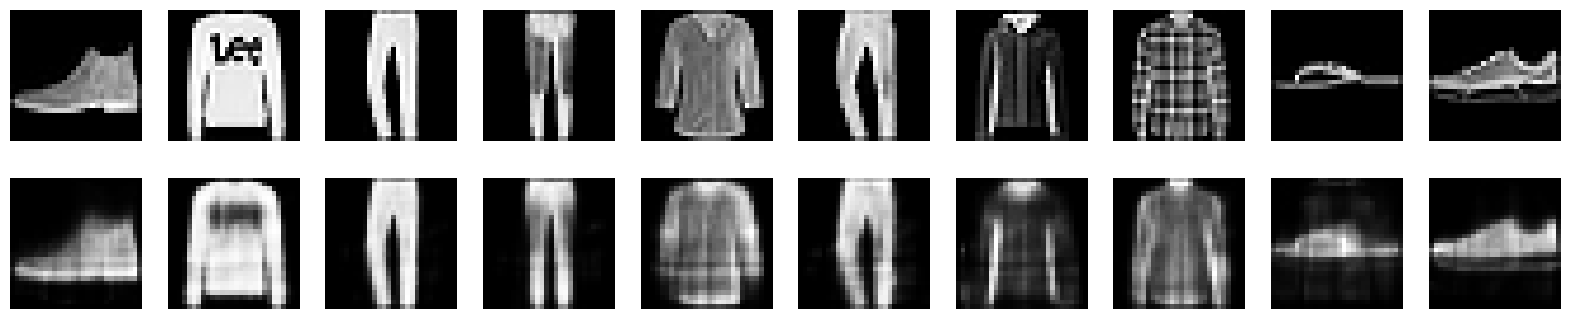

In [56]:
fig, axes = plt.subplots(ncols=n_classes, nrows=2, figsize=(20, 4))
for i in range(n_classes):

    axes[0, i].imshow(X_test_scaled[i].reshape(image_size, image_size), cmap='gray')
    axes[0, i].axis('off')

    axes[1, i].imshow(decoded_test_img[i].reshape(28, 28) , cmap='gray')
    axes[1, i].axis('off')

##  Deep Autoencoder

To illustrate the benefit of adding depth to the autoencoder, we build a three-layer feedforward model that successively compresses the input from 784 to 128, 64, and 34 units, respectively:

### Define three-layer architecture

In [60]:
input_ = Input(shape=(input_size,))
x = Dense(128, activation='relu')(input_)
x = Dense(64, activation='relu')(x)

encoding_deep = Dense(32, activation='relu', name='Encoding3')(x)

x = Dense(64, activation='relu')(encoding_deep)
x = Dense(128, activation='relu')(x)
decoding_deep = Dense(input_size, activation='sigmoid', name='Decoding3')(x)

In [61]:
autoencoder_deep = Model(input_, decoding_deep)


The resulting model has over 222,000 parameters, more than four times the capacity of the preceding single-layer model:

In [62]:
autoencoder_deep.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Encoding3 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Decoding3 (Dense)               │ (None, 784)            │       101,136 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 222,384 (868.69 KB)

 Trainable params: 222,384 (868.69 KB)

 Non-trainable params: 0 (0.00 B)

### Encoder & Decoder Models

In [63]:
encoder_deep = Model(inputs=input_, outputs=encoding_deep, name='Encoder')

In [64]:
encoded_input = Input(shape=(encoding_size,), name='Decoder_Input')

x = autoencoder_deep.layers[-3](encoded_input)
x = autoencoder_deep.layers[-2](x)
decoded = autoencoder_deep.layers[-1](x)

decoder_deep = Model(inputs=encoded_input, outputs=decoded)

In [65]:
decoder_deep.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Decoder_Input (InputLayer)      │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Decoding3 (Dense)               │ (None, 784)            │       101,136 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 111,568 (435.81 KB)

 Trainable params: 111,568 (435.81 KB)

 Non-trainable params: 0 (0.00 B)

### Train Model

In [69]:
path = 'models/fashion_mnist.autencoder_deep.32.weights.h5'

In [80]:
autoencoder_deep.compile(optimizer='adam',
                          loss='mse')
autoencoder_deep, mse = train_autoencoder(path, autoencoder_deep)

Epoch 1/100
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - loss: 0.0107 - val_loss: 0.0108
Epoch 2/100
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.0106 - val_loss: 0.0109
Epoch 3/100
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - loss: 0.0105 - val_loss: 0.0108
Epoch 4/100
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - loss: 0.0104 - val_loss: 0.0106
Epoch 5/100
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.0103 - val_loss: 0.0105
Epoch 6/100
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - loss: 0.0102 - val_loss: 0.0105
Epoch 7/100
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - loss: 0.0102 - val_loss: 0.0106
Epoch 8/100
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - loss: 0.0102 - val_loss: 0.0103
Epoch 9/100
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - loss: 0.0101 - val_loss: 0.0104
Epoch 10/100
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - loss: 0.0100 - val_loss: 0.0102
Epoch 11/100
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - loss: 0.0100 - val_loss: 0.0103
Epoch 12

KeyboardInterrupt: 

In [72]:
autoencoder_deep.load_weights(path)

### Evaluate Model

Training stops after 54 epochs and results in a ~10% reduction of the test RMSE to 0.1026. Due to the low resolution, it is difficult to visually note the better reconstruction.

In [73]:
f'MSE: {mse:.4f} | RMSE {mse**.5:.4f}'

'MSE: 0.0866 | RMSE 0.2944'

In [74]:
reconstructed_images = autoencoder_deep.predict(X_test_scaled)
reconstructed_images.shape

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


(10000, 784)

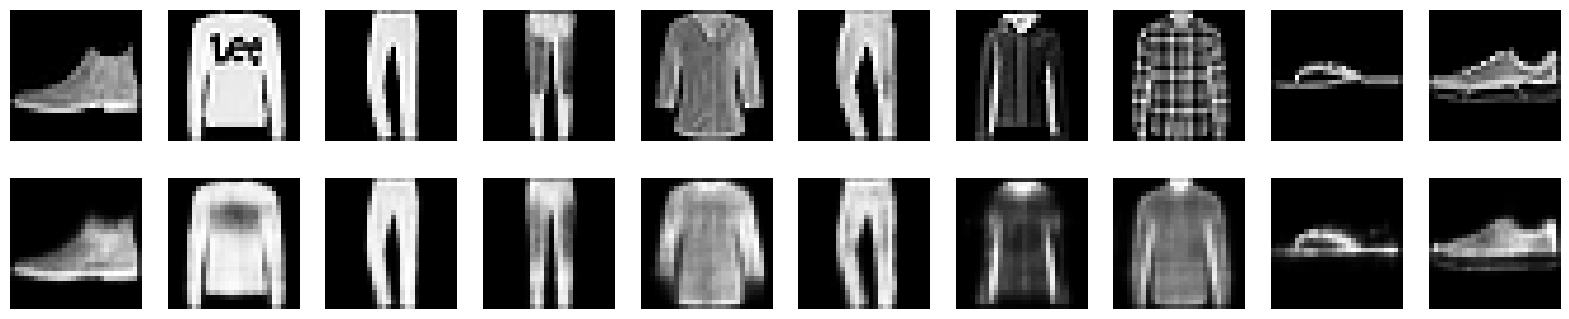

In [75]:
fig, axes = plt.subplots(ncols=n_classes, nrows=2, figsize=(20, 4))
for i in range(n_classes):

    axes[0, i].imshow(X_test_scaled[i].reshape(image_size, image_size), cmap='gray')
    axes[0, i].axis('off')

    axes[1, i].imshow(reconstructed_images[i].reshape(image_size, image_size) , cmap='gray')
    axes[1, i].axis('off')

### Compute t-SNE Embedding

We can use the t-distributed Stochastic Neighbor Embedding (t-SNE) manifold learning technique, see Chapter 12, Unsupervised Learning, to visualize and assess the quality of the encoding learned by the autoencoder's hidden layer.

If the encoding is successful in capturing the salient features of the data, the compressed representation of the data should still reveal a structure aligned with the 10 classes that differentiate the observations.

We use the output of the deep encoder we just trained to obtain the 32-dimensional representation of the test set:

Since t-SNE can take a long time to run, we are providing pre-computed results

In [94]:
# alternatively, compute the result yourself
# tsne = TSNE(perplexity=25, n_iter=5000)
train_embed = tsne.fit_transform(encoder_deep.predict(X_train_scaled))

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


#### Persist result

In [95]:
# store results given computational intensity (different location to avoid overwriting the pre-computed results)
pd.DataFrame(train_embed).to_hdf('tsne.h5', 'autoencoder_deep')

/tmp/ipython-input-1947026663.py:2: FutureWarning: Starting with pandas version 3.0 all arguments of to_hdf except for the argument 'path_or_buf' will be keyword-only.
  pd.DataFrame(train_embed).to_hdf('tsne.h5', 'autoencoder_deep')


#### Load pre-computed embeddings

In [96]:
# Load the pre-computed results here:
train_embed = pd.read_hdf('tsne.h5', 'autoencoder_deep')

#### Visualize Embedding

In [97]:
def plot_embedding(X, y=y_train, title=None, min_dist=0.1, n_classes=10, cmap=cmap):
    X = minmax_scale(X)
    inner = outer = 0
    for c in range(n_classes):
        inner += np.mean(pdist(X[y == c]))
        outer += np.mean(cdist(X[y == c], X[y != c]))
    fig, ax = plt.subplots(figsize=(14, 10))
    ax.axis('off')
    ax.set_title(title + ' | Distance: {:.2%}'.format(inner/outer))
    sc = ax.scatter(*X.T, c=y, cmap=ListedColormap(cmap), s=5);
    shown_images = np.ones((1, 2))
    images = X_train.reshape(-1, 28, 28)
    for i in range(0, X.shape[0]):
        dist = norm(X[i] - shown_images, axis=1)
        if (dist > min_dist).all():
            shown_images = np.r_[shown_images, [X[i]]]
            imagebox = AnnotationBbox(OffsetImage(images[i], cmap=plt.cm.gray_r), X[i])
            ax.add_artist(imagebox)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="2%", pad=0.05)
    plt.colorbar(sc, cax=cax)
    fig.tight_layout()
    fig.savefig('figures/tsne_autoencoder_deep', dpi=300)

The following figure shows that t-SNE manages to separate the 10 classes well, suggesting that the encoding is useful as a lower-dimensional representation that preserves key characteristics of the data:

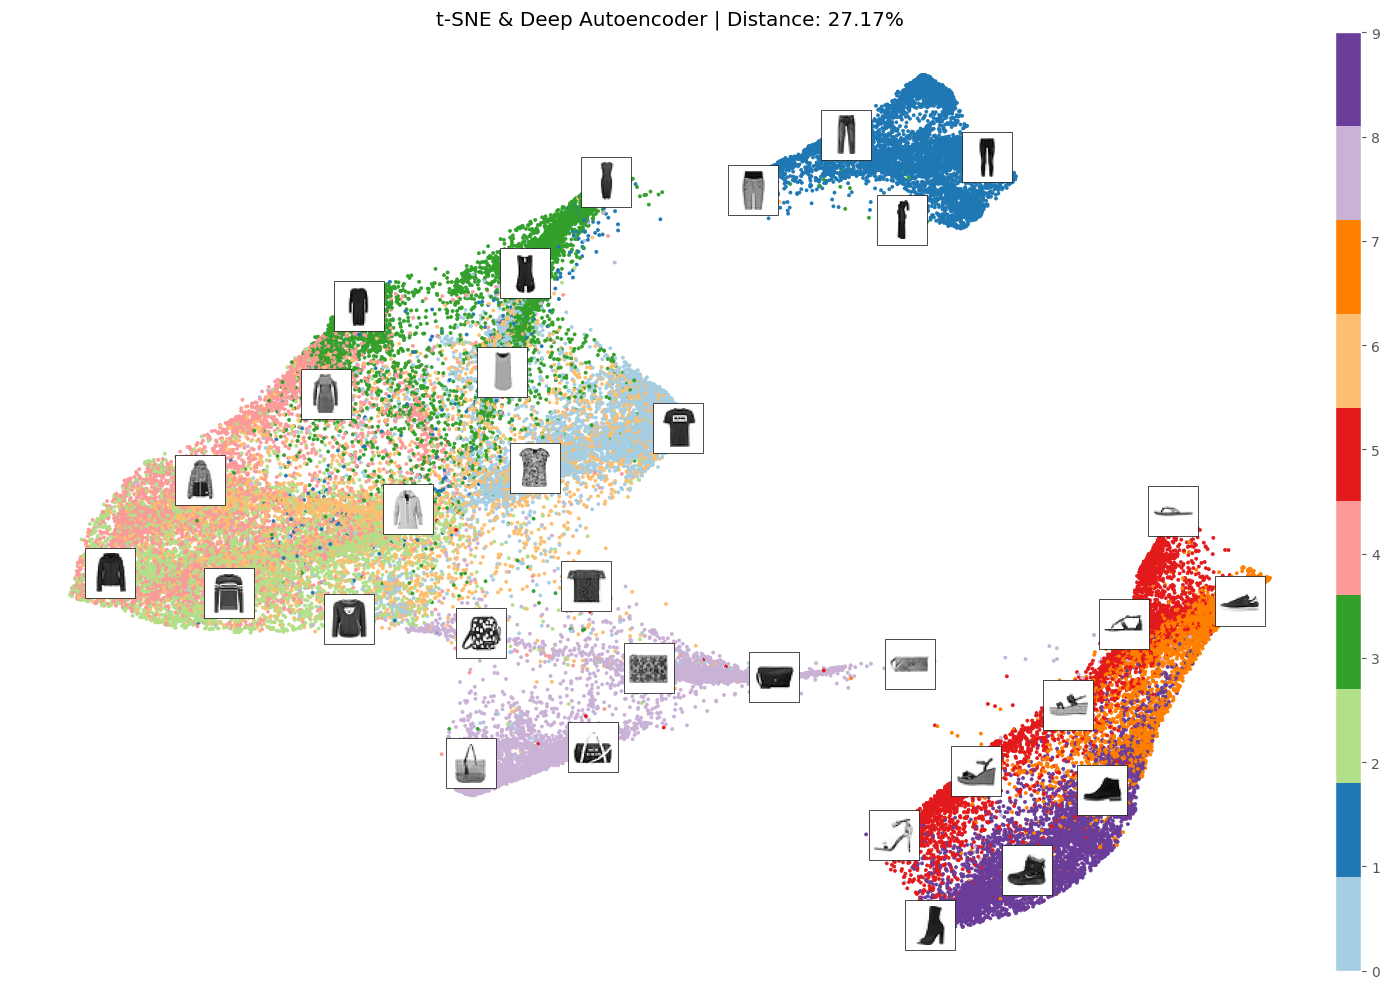

In [98]:
plot_embedding(X=train_embed, title='t-SNE & Deep Autoencoder')